Self Driving Car project

Get the dataset from my github

In [2]:
!rm -rf Self-driving-car-project
!git clone https://github.com/tarek-sanat/Self-driving-car-project
!ls track

Cloning into 'Self-driving-car-project'...
remote: Enumerating objects: 143665, done.
remote: Total 143665 (delta 0), reused 0 (delta 0), pack-reused 143665
Receiving objects: 100% (143665/143665), 1.73 GiB | 22.28 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (17782/17782), done.
ls: cannot access 'track': No such file or directory


In [3]:
#import dependencies
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ntpath
from sklearn.model_selection import train_test_split
import os
import random
import cv2
from imgaug import augmenters as iaa
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, Dropout, Flatten, Dense

In [4]:
#Display dataframe
df=pd.read_csv('Self-driving-car-project/driving_log.csv')
df.columns = columns=['centerIMG','leftIMG','rightIMG','steering','reverse','throttle','speed']
pd.set_option("display.max_colwidth", -1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,centerIMG,leftIMG,rightIMG,steering,reverse,throttle,speed
0,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\center_2021_11_27_20_17_10_841.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\left_2021_11_27_20_17_10_841.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\right_2021_11_27_20_17_10_841.jpg,0.0,0.0,0,0.000078
1,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\center_2021_11_27_20_17_10_942.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\left_2021_11_27_20_17_10_942.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\right_2021_11_27_20_17_10_942.jpg,0.0,0.0,0,0.000079
2,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\center_2021_11_27_20_17_11_043.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\left_2021_11_27_20_17_11_043.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\right_2021_11_27_20_17_11_043.jpg,0.0,0.0,0,0.000079
3,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\center_2021_11_27_20_17_11_143.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\left_2021_11_27_20_17_11_143.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\right_2021_11_27_20_17_11_143.jpg,0.0,0.0,0,0.000078
4,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\center_2021_11_27_20_17_11_245.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\left_2021_11_27_20_17_11_245.jpg,C:\Users\tarek\Desktop\driving sim\IMG\Self-driving-car-project\IMG\right_2021_11_27_20_17_11_245.jpg,0.0,0.0,0,0.000078


In [5]:
#Strip the image name of the path
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

#Strip the data of the OS Path 
df['centerIMG'] = df['centerIMG'].apply(path_leaf)
df['leftIMG'] = df['leftIMG'].apply(path_leaf)
df['rightIMG'] = df['rightIMG'].apply(path_leaf)
df.head()

,centerIMG,leftIMG,rightIMG,steering,reverse,throttle,speed
0,center_2021_11_27_20_17_10_841.jpg,left_2021_11_27_20_17_10_841.jpg,right_2021_11_27_20_17_10_841.jpg,0.0,0.0,0,0.000078
1,center_2021_11_27_20_17_10_942.jpg,left_2021_11_27_20_17_10_942.jpg,right_2021_11_27_20_17_10_942.jpg,0.0,0.0,0,0.000079
2,center_2021_11_27_20_17_11_043.jpg,left_2021_11_27_20_17_11_043.jpg,right_2021_11_27_20_17_11_043.jpg,0.0,0.0,0,0.000079
3,center_2021_11_27_20_17_11_143.jpg,left_2021_11_27_20_17_11_143.jpg,right_2021_11_27_20_17_11_143.jpg,0.0,0.0,0,0.000078
4,center_2021_11_27_20_17_11_245.jpg,left_2021_11_27_20_17_11_245.jpg,right_2021_11_27_20_17_11_245.jpg,0.0,0.0,0,0.000078


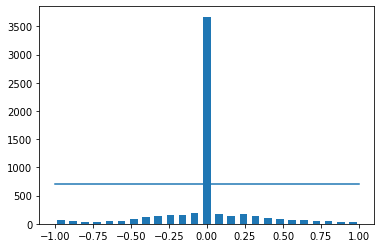

In [6]:
#Remove the middle values due to them being present more frequently and avoid huge bias towards center
num_bins = 25
samples_per_bin = 700
hist, bins = np.histogram(df['steering'], num_bins)

center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))

In [7]:
#Print removed entries
print('total data:', len(df))
remove_list = []
for j in range(num_bins):
  steeringList = []
  for i in range(len(df['steering'])):
    if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
      steeringList.append(i)
  steeringList = shuffle(steeringList)
  steeringList = steeringList[samples_per_bin:]
  remove_list.extend(steeringList)
 
print('removed:', len(remove_list))
df.drop(df.index[remove_list], inplace=True)
print('remaining:', len(df))

total data: 5925
removed: 2970
remaining: 2955


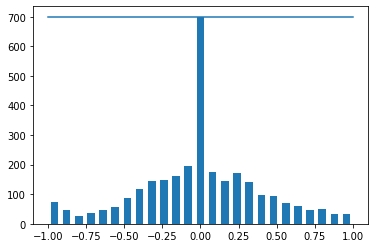

In [8]:
#New hist chart after trim
hist, x = np.histogram(df['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
print('Number of rows where steering is 0 remaining :',df[df.steering == 0 ].shape[0])

Number of rows where steering is 0 remaining : 667


In this project we will only consider the images columns and the steering angle.

In [10]:
image = []
steer = []
#loop through all dataframe
for i in range(len(df)):
  data = df.iloc[i]
  #from table up we can see that center image is first, left image second and right image third
  center,left,right = data[0], data[1], data[2]
  #append the center image to the array with its steering value at the same position
  image.append(os.path.join('Self-driving-car-project/IMG', center.strip()))
  steer.append(float(data[3]))

  #append left image and its steering position to array. We need to take into account the fact that the image was taken from the left so we add 0.10 to the angle
  image.append(os.path.join('Self-driving-car-project/IMG', left.strip()))
  steer.append(float(data[3]+0.15))
  #append left image and its steering position to array. We need to take into account the fact that the image was taken from the left so we add 0.10 to the angle 
  image.append(os.path.join('Self-driving-car-project/IMG', right.strip()))
  steer.append(float(data[3]-0.15))

image = np.array(image)
steer = np.array(steer)

Text(0.5, 1.0, '100 th image in array, Its steering angle is:0.15')

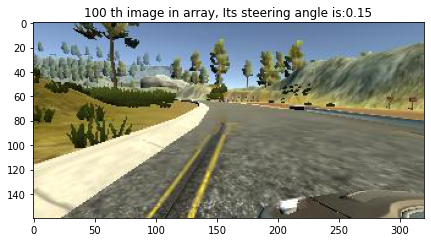

In [11]:
#Visualize an image in the dataset
image[0]
original_image = mpimg.imread(image[100])
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
 
axs.imshow(original_image)
axs.set_title('100 th image in array, Its steering angle is:'+ str(steer[100]))

In [12]:
#Split data into training and validation data:
X_train, X_valid, y_train, y_valid = train_test_split(image, steer, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 7092
Valid Samples: 1773


In [13]:
#We will now apply different augmentation techniques on our dataset to get more data out of it!

#flip image and its steering angle
def flipIMG(img, steer):
  img = cv2.flip(img,1)
  steer = -steer
  return img, steer

#change brightness of image
def brightnessIMG(img):
  brightness = iaa.Multiply((0.2,1.2))
  img = brightness.augment_image(img)
  return img

  #Zoom into the image
def zoomIMG(img):
  zoom = iaa.Affine(scale=(1, 1.3))
  img = zoom.augment_image(img)
  return img

In [14]:
#Visualize each augmentation technique:
imgPOS = random.randint(0, 1000)
displayIMG = mpimg.imread(image[imgPOS])

flippedIMG, flipSteer = flipIMG(displayIMG, steer[imgPOS])

brightIMG = brightnessIMG(displayIMG)

zoomedIMG = zoomIMG(displayIMG)

Text(0.5, 1.0, 'Zoom')

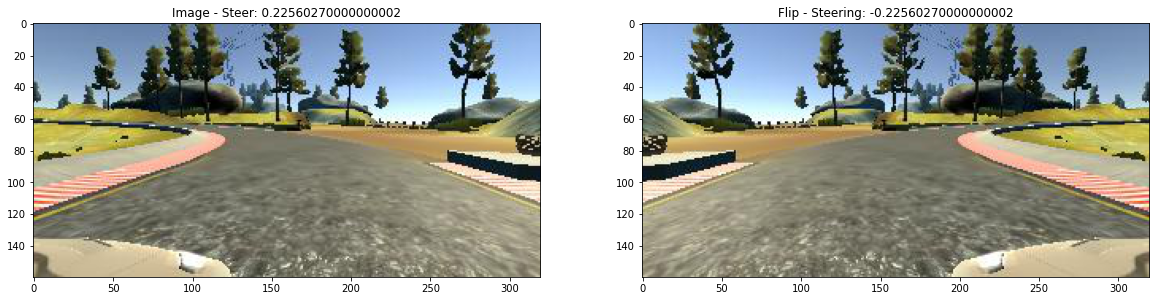

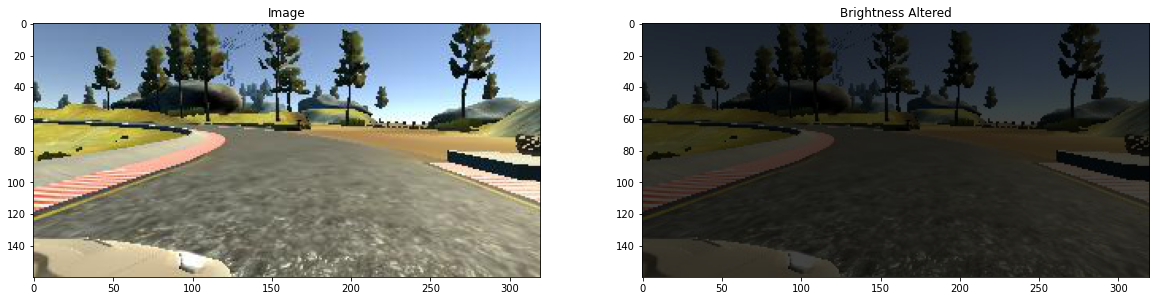

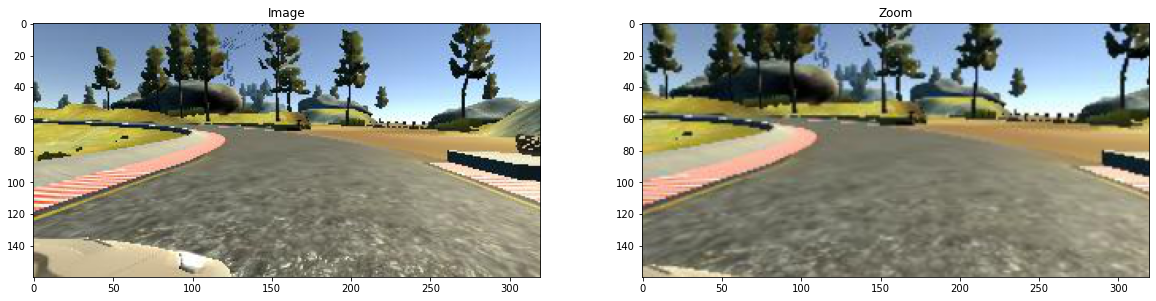

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(displayIMG)
axs[0].set_title('Image - ' + 'Steer: ' + str(steer[imgPOS]))
axs[1].imshow(flippedIMG)
axs[1].set_title('Flip - ' + 'Steering: ' + str(flipSteer))

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(displayIMG)
axs[0].set_title('Image')
axs[1].imshow(brightIMG)
axs[1].set_title('Brightness Altered')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(displayIMG)
axs[0].set_title('Image')
axs[1].imshow(zoomedIMG)
axs[1].set_title('Zoom')

In [16]:
#Process image: Rescale to 200 by 66 px since the nvidia model was trained on that and change color
def preprocessIMG(img):
  img = img[60:135,:,:]
  #change color pallet from rgb to YUV since the NVIDIA Model was also trained on that color encoding
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  #Use gaussian blur to smooth image
  img = cv2.GaussianBlur(img,  (3, 3), 0)
  #resize picture to correct shape accepted by model
  img = cv2.resize(img, (200, 66))
  #normalize image by dividing by 255
  img = img/255
  return img

Text(0.5, 1.0, 'Image that will be fed to CNN')

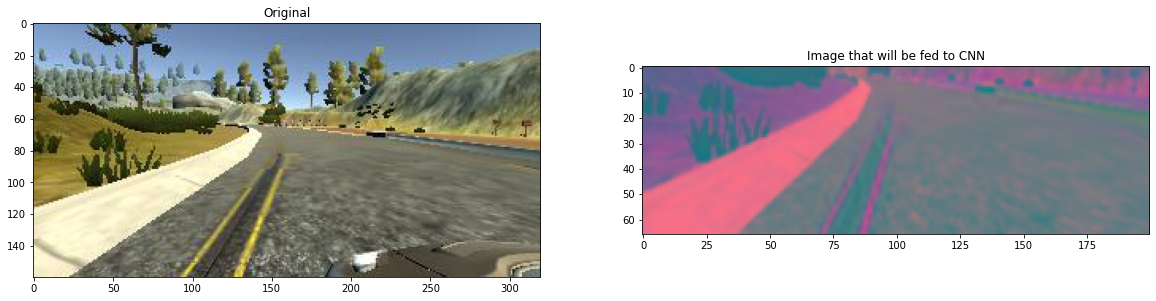

In [17]:
imageCNN = image[100]
original_image = mpimg.imread(imageCNN)
preprocessed_image = preprocessIMG(original_image)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(original_image)
axs[0].set_title('Original')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Image that will be fed to CNN')

In [18]:
def randomAug(img,steer):
  img = mpimg.imread(img)
  if np.random.rand() < 0.5:
    img = zoomIMG(img)
  if np.random.rand() < 0.5:
    img = brightnessIMG(img)
  if np.random.rand() < 0.5:
    img, steer = flipIMG(img,steer)
  return img, steer

In [19]:
#Generate batch CODE From website: https://www.codeproject.com/Articles/1273179/A-Complete-guide-to-self-driving-Car
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = randomAug(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = preprocessIMG(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [20]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

In [21]:
#implementation of this neural network https://developer.nvidia.com/blog/deep-learning-self-driving-cars/
def nvidia_model():
 
  model = Sequential()
  
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  
  model.add(Convolution2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Convolution2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))  
  model.add(Dense(50, activation='elu'))
  model.add(Dense(10, activation ='elu'))
  model.add(Dense(1))
  optimizer= Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  
  return model

In [22]:
#First model trained over 10 epochs

model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


None
Epoch 1/10
300/300 [==============================] - 173s 538ms/step - loss: 0.1369 - val_loss: 0.1111
Epoch 2/10
300/300 [==============================] - 154s 516ms/step - loss: 0.1149 - val_loss: 0.1098
Epoch 3/10
300/300 [==============================] - 155s 520ms/step - loss: 0.1086 - val_loss: 0.1124
Epoch 4/10
300/300 [==============================] - 156s 523ms/step - loss: 0.1044 - val_loss: 0.1014
Epoch 5/10
300/300 [==============================] - 156s 521ms/step - loss: 0.1024 - val_loss: 0.1042
Epoch 6/10
300/300 [==============================] - 156s 522ms/step - loss: 0.0955 - val_loss: 0.1012
Epoch 7/10
300/300 [==============================] - 156s 523ms/step - loss: 0.0969 - val_loss: 0.0971
Epoch 8/10
300/300 [==============================] - 156s 522ms/step - loss: 0.0945 - val_loss: 0.0958
Epoch 9/10
300/300 [==============================] - 156s 521ms/step - loss: 0.0912 - val_loss: 0.0944
Epoch 10/10
300/300 [==============================] - 171s

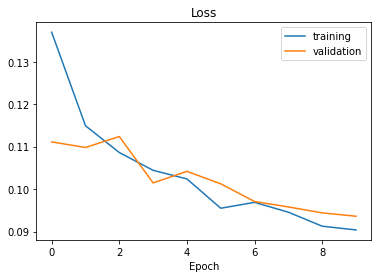

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model.h5')
#files.download('model.h5')

In [ ]:
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model2 = nvidia_model()
print(model.summary())
history = model2.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=25,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [ ]:
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model2 = nvidia_model()
print(model.summary())
history = model2.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=400, 
                                  epochs=25,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

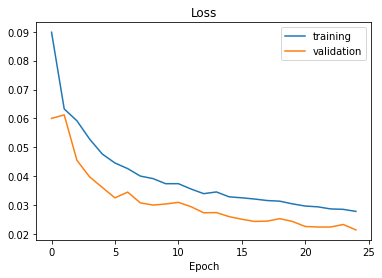

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')
model.save('model.h5')
files.download('model.h5')